In [1]:
%matplotlib inline

## Definitions
### These are values defined in the Arduino code and documented in "Bluetooth.java" in the application

In [2]:
D_SAMPLING_FREQUENCY = 250.0

### Pull in the libraries and define the functions we will be using

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

### This function pulls in the data for each channel

In [4]:
def getChannelData(iChannel, strTestCase):
    cwd = os.getcwd()
    cwd = cwd+'\\TrainingData\\'+strTestCase

    f = []
    for (dirpath, dirnames, filenames) in os.walk(cwd):
        f.extend(filenames)
        break
        
    strFileSearch = 'Trace0' + str(iChannel)
    strFiles = filter(lambda x:strFileSearch in x, f)
    
    
    for idx in range(0, len(strFiles)):
        fh = open(cwd+'\\'+strFiles[idx], 'rb')
        # read the data into numpy
        if(idx==0):
            x = np.fromfile(fh, dtype=('>f'))
        else:
            x = np.append(x, np.fromfile(fh, dtype=('>f')))
        fh.close()
    
    return (x,strFiles)

### A clever way of calculating the RMS values, from: http://stackoverflow.com/questions/8245687/numpy-root-mean-squared-rms-smoothing-of-a-signal

In [5]:
def getRMS(data, window_size):
    data2 = np.power(data,2)
    window = np.ones(window_size)/float(window_size)
    return np.sqrt(np.convolve(data2, window, 'same'))

### This function returns a new data frame with rolling RMS values

In [6]:
def getDataFrameRMS(dfData):
    
    dfRMS = dfData.copy(deep=True)
    
    for column in dfData:
        data = np.array(dfData[column])
        dfRMS[column] = getRMS(data, 11)
        
    dfRMS.columns = dfData.columns+'_rms'
        
    return dfRMS

### Calculate the peak values for an array. The signal processing model is:
#### - Remove the mean
#### - Rectify the signal
#### - Lowpass filter (using a moving average filter kernel and convolution)

In [7]:
def getPk(data, window_size):
    mn = np.mean(data)
    dataPk = np.absolute(data-mn)
    window = np.ones(window_size)/float(window_size)
    return (np.convolve(dataPk, window, 'same')+mn)

### This function calculates peak values for each column in the entire data frame

In [8]:
def getDataFramePk(dfData, window_size):
    
    dfPk = dfData.copy(deep=True)
    
    for column in dfPk:
        data = np.array(dfData[column])
        dfPk[column] = getPk(data, window_size)
        
    dfPk.columns = dfData.columns+'_pk'
        
    return dfPk

### This function pulls the arrays from the data file function into a single data frame and addes the extracted values

In [9]:
def getDataAsFrame(strTestCase):

    (x1,strFiles1) = getChannelData(1,strFolder)
    (x2,strFiles2) = getChannelData(2,strFolder)
    (x3,strFiles3) = getChannelData(3,strFolder)
    (x4,strFiles4) = getChannelData(4,strFolder)

    dfData = pd.DataFrame(data={(strTestCase+'_Ch1'):x1, 
                                (strTestCase+'_Ch2'):x2, 
                                (strTestCase+'_Ch3'):x3, 
                                (strTestCase+'_Ch4'):x4})
    
    # These lines add the rolling average
    dfDataRollingMean = dfData.rolling(window=15,center=True).mean()
    dfDataRollingMean.columns = [(strTestCase+'_Ch1_rm'),
                                (strTestCase+'_Ch2_rm'),
                                (strTestCase+'_Ch3_rm'),
                                (strTestCase+'_Ch4_rm')]
    
    for column in dfDataRollingMean:
        dfDataRollingMean[column].fillna(dfDataRollingMean[column].mean(), inplace=True)
        
    # Rolling RMS
    dfDataRMS = getDataFrameRMS(dfData)
    
    # RMS of the rolling mean
    dfDataRM_RMS = getDataFrameRMS(dfDataRollingMean)
    
    # Rolling peak value
    window_size = 3
    dfDataPk = getDataFramePk(dfData, window_size)
    
    # Peak value of the rolling mean
    window_size = 11
    dfDataRM_Pk = getDataFramePk(dfDataRollingMean, window_size)
    
    # Aggregate the dataframes
    dfData = pd.concat([dfData, dfDataRollingMean, dfDataRMS, dfDataRM_RMS, dfDataPk, dfDataRM_Pk],
                       axis=1, join_axes = [dfData.index])
    
    return dfData

### This function appends one dataframe to another

In [10]:
def appendDataAsFrame(strTestCase, dfData):
    dfNew = getDataAsFrame(strTestCase)
    dfDataOut = pd.concat([dfData, dfNew], axis=1, join_axes=[dfData.index])

    return dfDataOut

### This function plots the timebase data in the data frame

In [11]:
def plotFolder(strFolder):
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.subplots_adjust(wspace=.5, hspace=0.5)

    strColName = strFolder+'_Ch1'
    ax = dfData.plot(x='t', y=[strColName, strColName+'_rm', strColName+'_pk'], 
                     ax=axes[0,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

    strColName = strFolder+'_Ch2'
    ax = dfData.plot(x='t', y=[strColName, strColName+'_rm', strColName+'_pk'], 
                     ax=axes[0,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

    strColName = strFolder+'_Ch3'
    ax = dfData.plot(x='t', y=[strColName, strColName+'_rm', strColName+'_pk'], 
                     ax=axes[1,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

    strColName = strFolder+'_Ch4'
    ax = dfData.plot(x='t', y=[strColName, strColName+'_rm', strColName+'_pk'], 
                     ax=axes[1,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

### Helper function for the plotClasses below

In [12]:
def plotClassesHelper(dfData, strSeries, axesin):
    ax1 = dfData[strSeries].plot.hist(figsize=(12,12), ax=axesin, alpha = 0.4, label=strSeries)
    return ax1

### This function plots the histograms of two different classes of data

In [13]:
def plotClasses(strClass, strSuff):
    
    iSeries = len(strClass)
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    strSeries = pd.Series(strClass)+'_Ch1'+strSuff
    ax1 = plotClassesHelper(dfData, strSeries, axes[0, 0])
    ax1.legend()

    strSeries = pd.Series(strClass)+'_Ch2'+strSuff
    ax1 = plotClassesHelper(dfData, strSeries, axes[0, 1])
    ax1.legend()

    strSeries = pd.Series(strClass)+'_Ch3'+strSuff
    ax1 = plotClassesHelper(dfData, strSeries, axes[1, 0])
    ax1.legend()

    strSeries = pd.Series(strClass)+'_Ch4'+strSuff
    ax1 = plotClassesHelper(dfData, strSeries, axes[1, 1])
    ax1.legend()


### Plot correlation by channel

In [14]:
def plotCorrChannel(strChannel):
    
    # Section the data and calc correlation matrix
    plot_cols = [col for col in dfData.columns if strChannel in col]
    dfPlot = dfData[plot_cols]
    correlations = dfPlot.corr()
    names = list(dfPlot)
    iCols = len(dfPlot.columns)
    
    # plot correlation matrix
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,iCols,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

### Begin by getting the data into python and plotting it out.

In [15]:
strFolder = 'Cobble1'
dfData = getDataAsFrame(strFolder)
strFolder = 'Cobble2'
dfData = appendDataAsFrame(strFolder, dfData)
strFolder = 'Carpet1'
dfData = appendDataAsFrame(strFolder, dfData)
strFolder = 'Carpet2'
dfData = appendDataAsFrame(strFolder, dfData)
strFolder = 'Tile1'
dfData = appendDataAsFrame(strFolder, dfData)
strFolder = 'Tile2'
dfData = appendDataAsFrame(strFolder, dfData)

dfData['t'] = pd.Series(np.divide(range(0,len(dfData.index)),D_SAMPLING_FREQUENCY), 
                        index=dfData.index)

### Plot out the data

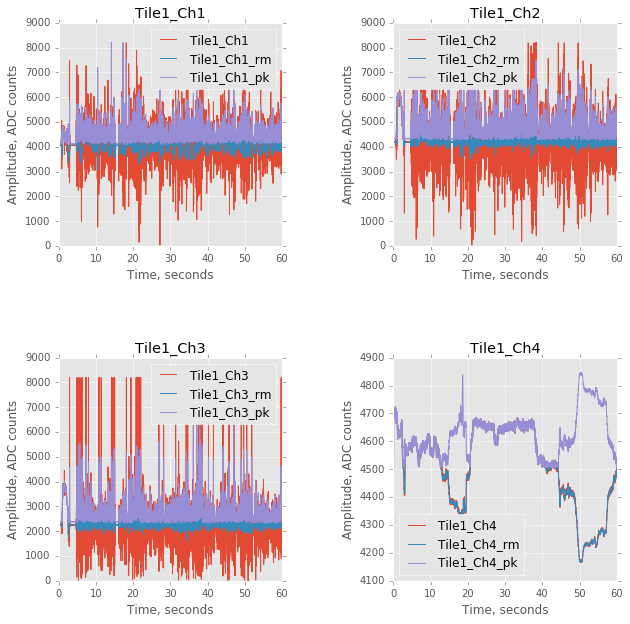

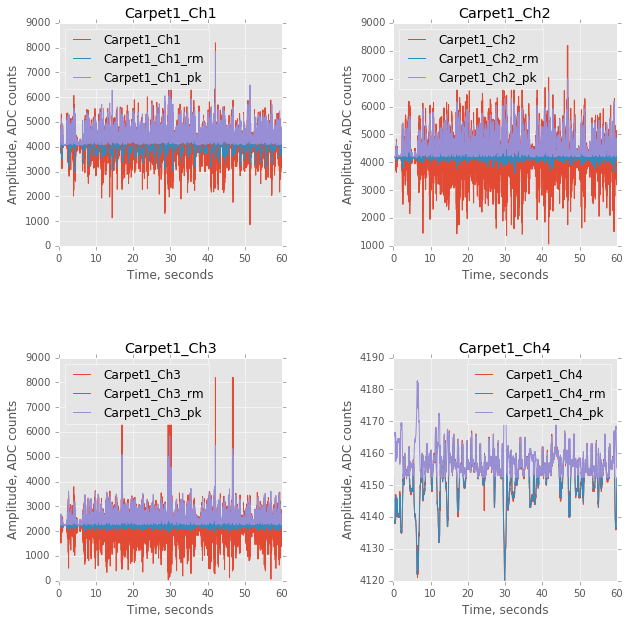

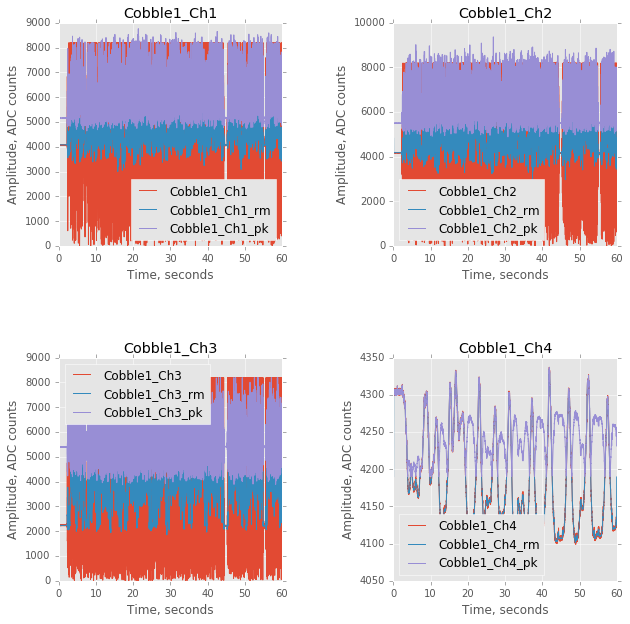

In [16]:
plotFolder('Tile1')
plotFolder('Carpet1')
plotFolder('Cobble1')

In [17]:
dfData.head(10)

,Cobble1_Ch1,Cobble1_Ch2,Cobble1_Ch3,Cobble1_Ch4,Cobble1_Ch1_rm,Cobble1_Ch2_rm,Cobble1_Ch3_rm,Cobble1_Ch4_rm,Cobble1_Ch1_rms,Cobble1_Ch2_rms,...,Tile2_Ch4_rm_rms,Tile2_Ch1_pk,Tile2_Ch2_pk,Tile2_Ch3_pk,Tile2_Ch4_pk,Tile2_Ch1_rm_pk,Tile2_Ch2_rm_pk,Tile2_Ch3_rm_pk,Tile2_Ch4_rm_pk,t
0,4080.0,4178.0,2237.0,4301.0,4619.763802,4841.966836,3820.884274,4189.551337,3013.403557,3089.351506,...,3176.040304,4078.421956,4175.536947,2332.427897,4304.468099,4076.344566,4170.572481,2297.693981,4300.378900,0.000
1,4081.0,4181.0,2227.0,4301.0,4619.763802,4841.966836,3820.884274,4189.551337,3254.259251,3337.108792,...,3430.515609,4081.666667,4178.666667,2349.646810,4306.666667,4076.344566,4170.572481,2297.693981,4300.378900,0.004
2,4084.0,4188.0,2239.0,4301.0,4619.763802,4841.966836,3820.884274,4189.551337,3478.797075,3567.062555,...,3668.145786,4082.333333,4180.000000,2350.980143,4307.333333,4076.604151,4171.217407,2302.757070,4301.035364,0.008
3,4077.0,4181.0,2242.0,4302.0,4619.763802,4841.966836,3820.884274,4189.551337,3690.299027,3782.963869,...,3891.278099,4082.000000,4179.666667,2354.980143,4308.000000,4076.869796,4171.868394,2307.814099,4301.679706,0.012
4,4076.0,4188.0,2240.0,4302.0,4619.763802,4841.966836,3820.884274,4189.551337,3890.987921,3987.763420,...,4102.266219,4079.666667,4178.000000,2356.313477,4309.000000,4077.105139,4172.476956,2312.901430,4302.299806,0.016
5,4083.0,4182.0,2237.0,4304.0,4619.763802,4841.966836,3820.884274,4189.551337,4080.094039,4182.546897,...,4302.890888,4080.333333,4177.666667,2355.313477,4310.000000,4077.267754,4173.091579,2317.988762,4302.889603,0.020
6,4075.0,4185.0,2233.0,4303.0,4619.763802,4841.966836,3820.884274,4189.551337,4080.184956,4183.092114,...,4303.444355,4079.333333,4176.333333,2355.646810,4310.000000,4077.430369,4173.669838,2323.094275,4303.443037,0.024
7,4078.0,4179.0,2232.0,4305.0,4079.600000,4183.400000,2235.800000,4304.400000,4079.458186,4184.001716,...,4303.949240,4080.000000,4177.000000,2356.313477,4309.333333,4077.568742,4174.272340,2328.133122,4303.947985,0.028
8,4084.0,4178.0,2235.0,4306.0,4080.000000,4183.533333,2235.466667,4304.533333,4079.185246,4183.728828,...,4304.399505,4079.000000,4177.333333,2354.313477,4308.333333,4077.701054,4174.899084,2333.171969,4304.398388,0.032
9,4091.0,4184.0,2236.0,4308.0,4079.666667,4183.466667,2236.000000,4304.666667,4079.276117,4183.910567,...,4304.783054,4079.177246,4178.666667,2349.313477,4307.666667,4077.784882,4175.531889,2338.156270,4304.782124,0.036


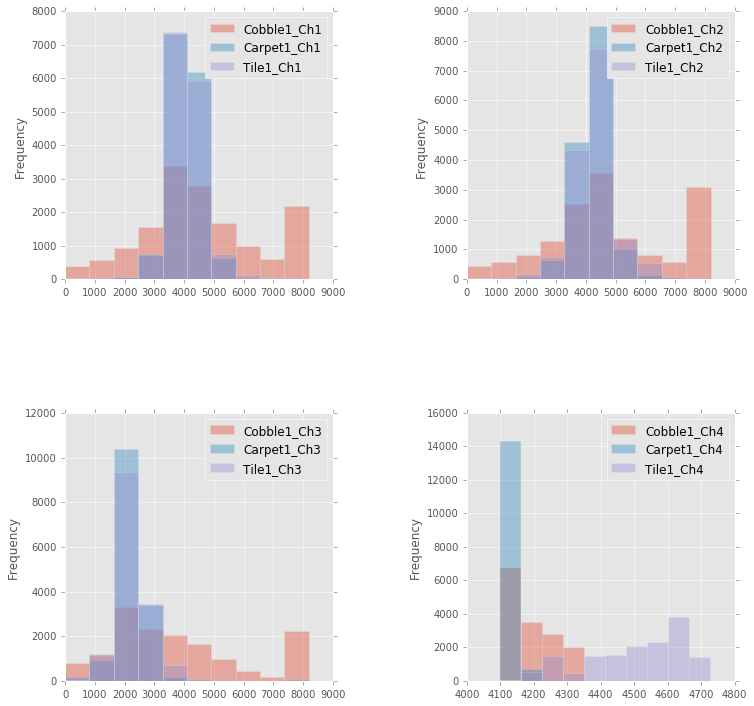

In [18]:
strClass = ['Cobble1', 'Carpet1', 'Tile1']
strSuff = ''
plotClasses(strClass, strSuff)

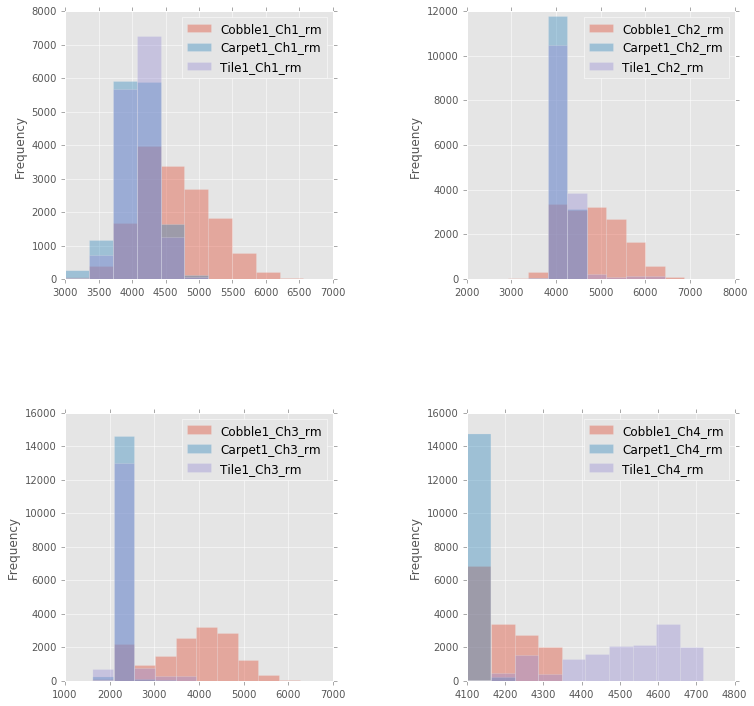

In [19]:
strSuff = '_rm'
plotClasses(strClass, strSuff)

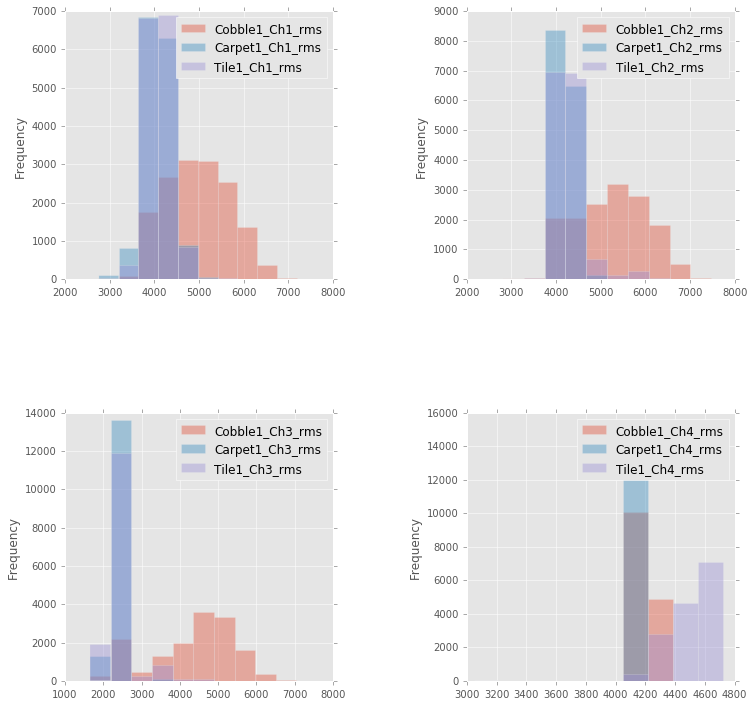

In [20]:
strSuff = '_rms'
plotClasses(strClass, strSuff)

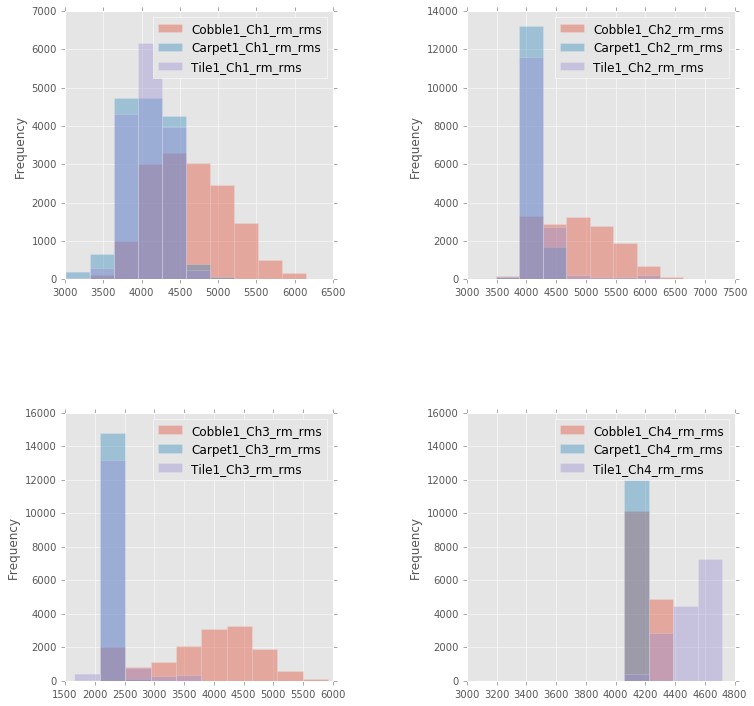

In [21]:
strSuff = '_rm_rms'
plotClasses(strClass, strSuff)

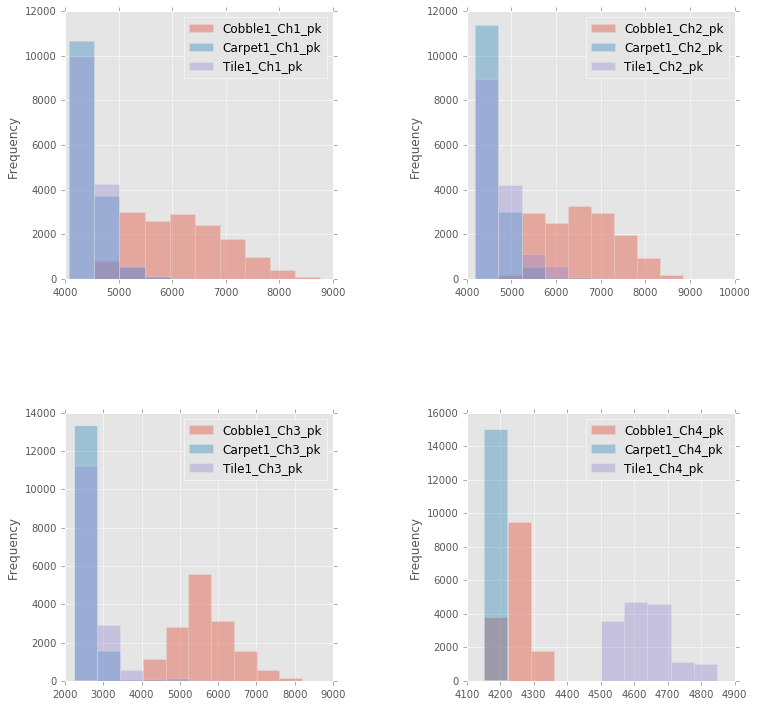

In [22]:
strSuff = '_pk'
plotClasses(strClass, strSuff)

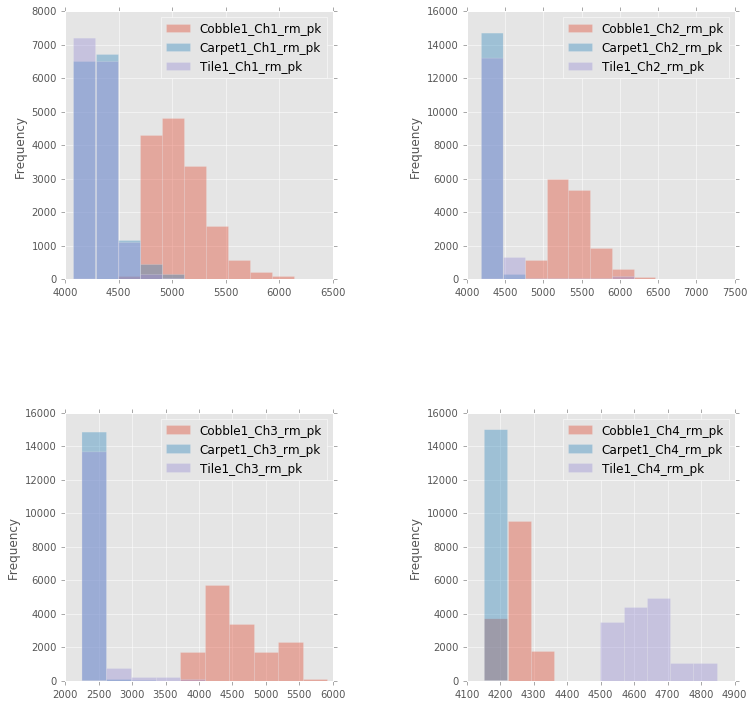

In [23]:
strSuff = '_rm_pk'
plotClasses(strClass, strSuff)